In [68]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

## 加载数据

In [69]:
from fastai.vision import *

In [70]:
root = Config.data_path()/'aerial-cactus-identification'
root
root.as_posix()

PosixPath('/home/lyc/.fastai/data/aerial-cactus-identification')

'/home/lyc/.fastai/data/aerial-cactus-identification'

- 下载数据

In [71]:
# !kaggle competitions download -c aerial-cactus-identification -p {root.as_posix()}

- 解压缩

In [72]:
# !unzip {root/'train.zip'} -d {root}
# !unzip {root/'test.zip'} -d {root}

- 读入标签

In [73]:
train_df = pd.read_csv(root/"train.csv")
test_df = pd.read_csv(root/"sample_submission.csv")

In [74]:
train_df.head()
test_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


- 测试集构造

In [75]:
test_set = ImageList.from_df(test_df, path=root, cols='id', folder='test')

In [76]:
test_set

ImageList (4000 items)
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
Path: /home/lyc/.fastai/data/aerial-cactus-identification

- transforms 定义

In [77]:
tsfm = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)

- databunch 构造

In [78]:
np.random.seed(42)
data = (ImageList.from_df(train_df, path=root, cols='id', folder='train')
       .split_by_rand_pct(0.01)
       .label_from_df()
       .transform(tsfm, size=128)
       .databunch(bs=64)
       .normalize(imagenet_stats)
      )

In [79]:
data

ImageDataBunch;

Train: LabelList (17325 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,1,1,1,1
Path: /home/lyc/.fastai/data/aerial-cactus-identification;

Valid: LabelList (175 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,1,1
Path: /home/lyc/.fastai/data/aerial-cactus-identification;

Test: None

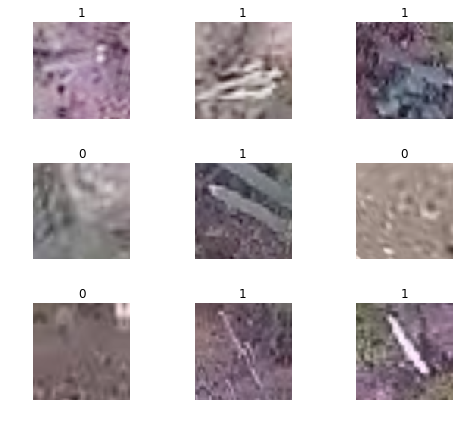

In [80]:
data.show_batch(rows=3, figsize=(7,6))

- 构造模型

## 使用残差网络

In [81]:
arch = models.resnet34
# arch = models.resnet50

In [82]:
learn = cnn_learner(data, arch, metrics=[error_rate, accuracy])

- 寻找最佳学习率

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


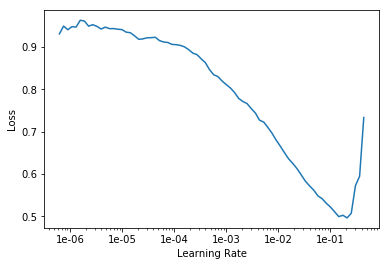

In [83]:
learn.lr_find()
learn.recorder.plot()

In [84]:
lr = 3e-05
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.791614,0.533831,0.234286,0.765714,00:21
1,0.523685,0.296369,0.120000,0.880000,00:20
2,0.377952,0.205061,0.074286,0.925714,00:20
3,0.285416,0.156714,0.045714,0.954286,00:20
4,0.220806,0.114321,0.034286,0.965714,00:20
5,0.201388,0.103401,0.040000,0.960000,00:20
6,0.180807,0.088959,0.028571,0.971429,00:19
7,0.178137,0.089591,0.034286,0.965714,00:19
8,0.163024,0.084959,0.028571,0.971429,00:19
9,0.174759,0.083852,0.028571,0.971429,00:19


- 第二阶段

In [85]:
learn.unfreeze()

- 再次寻找学习率

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


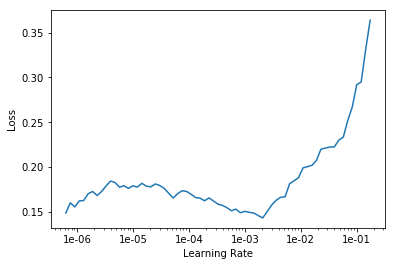

In [86]:
learn.lr_find()
learn.recorder.plot()

In [87]:
lr1 = 1e-04
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.144643,0.072360,0.017143,0.982857,00:28
1,0.101121,0.035474,0.005714,0.994286,00:28
2,0.065555,0.021869,0.000000,1.000000,00:28
3,0.048327,0.020468,0.005714,0.994286,00:28
4,0.049405,0.016423,0.000000,1.000000,00:29


In [88]:
learn.save('resnet34-stage2')
learn.export()

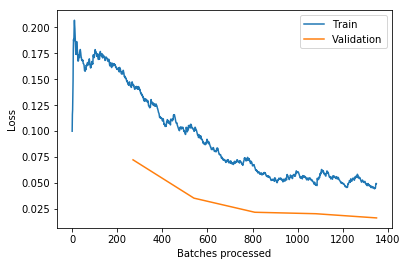

In [89]:
learn.recorder.plot_losses()

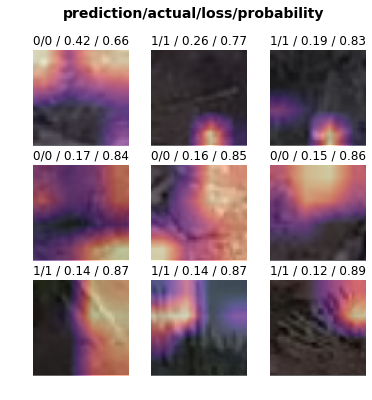

In [90]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(6,6))

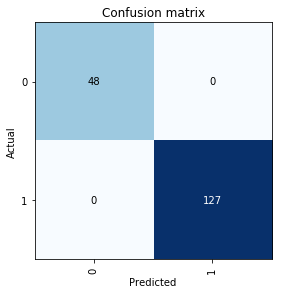

In [91]:
interp.plot_confusion_matrix()

## 预测并提交结果

- 加载最佳模型

In [92]:
learn = load_learner(path, test=test_set)

In [93]:
preds,_ = learn.get_preds(ds_type=DatasetType.Test)

In [94]:
preds[:5]

tensor([[0.0069, 0.9931],
        [0.0021, 0.9979],
        [0.9927, 0.0073],
        [0.9966, 0.0034],
        [0.0198, 0.9802]])

In [95]:
test_df.has_cactus = preds.numpy()[:, 0]

In [96]:
test_df.to_csv(path/'submission.csv', index=False)

- 提交结果

In [97]:
# ! kaggle competitions submit aerial-cactus-identification -f {path/'submission.csv'} -m "My submission"